In [1]:
# !curl https://cdn.iconicto.com/Speculo/fingerprinter/datasets/test_set.tar.gz -o test_set.tar.gz
# !curl https://cdn.iconicto.com/Speculo/fingerprinter/datasets/train_set.tar.gz -o train_set.tar.gz

In [2]:
# !tar -xf test_set.tar.gz
# !tar -xf train_set.tar.gz

In [3]:
# %tensorflow_version 2.x
# import os
# import pickle
# import random
# from tqdm import tqdm

# BASE_DIR = ""

# data = []
# if not os.path.isdir(os.path.join(BASE_DIR, "dataset_processed")):
#     raise FileNotFoundError("fingerprinter/dataset_processed was not found")
# for person in tqdm(os.listdir(os.path.join(BASE_DIR, "dataset_processed"))):
#     for Y in os.listdir(os.path.join(BASE_DIR, "dataset_processed", person, "Y")):
#         for X in os.listdir(os.path.join(BASE_DIR, "dataset_processed", person, "X")):
#             if X.split(".")[0].split("_")[-1] == Y.split(".")[0].split("_")[-1]:
#                 data.append([os.path.join(BASE_DIR, "dataset_processed", person, "X", X),
#                              os.path.join(BASE_DIR, "dataset_processed", person, "Y", Y)])


# random.shuffle(data)
# if not os.path.isdir(os.path.join(BASE_DIR, "dataset")):
#     os.makedirs(os.path.join(BASE_DIR, "dataset"))
# file = open(os.path.join(BASE_DIR, "dataset", "youtube_data_map.pkl"), 'wb')
# pickle.dump(data, file)
# file.close()


In [4]:
import pickle
from sklearn.utils import shuffle
from PIL import Image
import os
import numpy as np
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    MaxPooling2D, BatchNormalization, Flatten, Reshape, Activation, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow import keras


class AutoEncoderProgress(keras.callbacks.Callback):
    def __init__(self, model, n_epoch=1):
        super().__init__()
        self.speculo = model
        self.n_epoch = n_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n_epoch == 0:
            self.speculo.evaluate(f'Model Predictions on epoch {epoch}',
                                  f'models/{self.speculo.model_number}/img/predictions-epoch-{epoch}.png')
        if os.path.isfile(".stop_training"):
            print("Stopping training because .stop_training was found")
            self.model.stop_training = True


class Speculo:
    def __init__(self, image_size=(128, 128, 1), model_path=None, visualize=True, batch_size=64):
        self.optimizer = 'adam'
        self.loss_function = 'mse'
        self.LR = 1e-3

        self.encoder_filters = (512, 256, 128)
        self.decoder_filters = (128, 256)
        self.input_shape = image_size
        self.output_shape = (64, 64, 1)
        self.latent_size = 256

        self.image_size = image_size
        self.model_path = model_path
        self.visualize = visualize
        self.dataset_size = 0
        self.batch_size = batch_size
        self.n_epochs = 4
        self.steps_per_epoch = 256

        model_number = 1
        if os.path.isdir("models"):
            model_number += len(os.listdir("models"))

        self.model_number = f"{model_number}"

        self.model = None

    def _build_model(self):
        input_img = Input(shape=self.image_size, name="input")
        x = input_img

        for i, f in enumerate(self.encoder_filters):
            x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)
            if (i + 1) % 2 == 0:
                x = Dropout(0.2)(x)

        size = K.int_shape(x)
        x = Flatten()(x)
        x = Dense(self.latent_size, name="latent_space")(x)

        x = Dense(np.prod(size[1:]))(x)
        x = Reshape((size[1], size[2], size[3]))(x)

        for i, f in enumerate(self.decoder_filters):
            x = Conv2DTranspose(f, (3, 3), strides=2, activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            if i % 2 == 0:
                x = Dropout(0.2)(x)

        x = Conv2DTranspose(self.image_size[2], (3, 3), activation='relu', padding='same')(x)
        output = Activation("sigmoid", name="output")(x)

        return Model(inputs=input_img, outputs=output, name=f"Speculo-v{self.model_number}")

    def autoencoder(self):
        autoencoder = self._build_model()
        autoencoder.compile(optimizer=self.optimizer, loss=self.loss_function)
        return autoencoder

    def display_image_array(self, n, *image_sets, figsize=(8, 4), title=None, labels=None, save_dir=None, shapes=None):
        plt.figure(figsize=figsize)
        if title:
            plt.suptitle(title)
        i = 1
        row = 0
        if labels and len(labels) != len(image_sets):
            labels = None
        for image_set in image_sets:
            for x in range(n):
                ax = plt.subplot(len(image_sets), n, i)
                if x == 0 and labels:
                    ax.set_title(labels[row])
                if shapes and shapes[row]:
                    if shapes[row][2] == 1:
                        plt.imshow(image_set[x].reshape(shapes[row][:2]))
                        plt.gray()
                    else:
                        plt.imshow(image_set[x].reshape(shapes[row]))
                else:
                    if self.image_size[2] == 1:
                        plt.imshow(image_set[x].reshape(self.image_size[:2]))
                        plt.gray()
                    else:
                        plt.imshow(image_set[x].reshape(self.image_size))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                i += 1
            row += 1
        if save_dir:
            plt.savefig(save_dir)
        plt.show()

    def read_image(self, file, output=False):
        im = Image.open(file)
        if output:
            im = im.resize(self.output_shape[:2], Image.ANTIALIAS)
        else:
            im = im.resize(self.input_shape[:2], Image.ANTIALIAS)
        if self.image_size[2] == 1:
            im = im.convert('L')
        return np.array(im)

    def _load_image_set(self, directory):
        x, y = [], []
        fronts = sorted(os.listdir(f"dataset/{directory}/Front/"))
        for i, person_dir in enumerate(sorted(os.listdir(f"dataset/{directory}"))):
            if person_dir == "Front":
                continue
            else:
                y_image = self.read_image(f"dataset/{directory}/Front/{fronts[i - 1]}", output=True)
                for image in os.listdir(f"dataset/{directory}/{person_dir}"):
                    x_image = self.read_image(f"dataset/{directory}/{person_dir}/{image}")
                    x.append(np.array(x_image))
                    y.append(np.array(y_image))

        x = np.array(x).astype("float32") / 255.0
        y = np.array(y).astype("float32") / 255.0
        x = x.reshape([-1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        y = y.reshape([-1, self.output_shape[0], self.output_shape[1], self.output_shape[2]])
        x, y = shuffle(x, y)
        return tf.data.Dataset.from_tensor_slices((x, y))

    def _image_set_generator(self):
        if not os.path.isfile("dataset/youtube_data_map.pkl"):
            raise FileNotFoundError("dataset/youtube_data_map.pkl was not found")
        file = open('dataset/youtube_data_map.pkl', 'rb')
        data = pickle.load(file)
        self.dataset_size = len(data)
        for x, y in data:
            x = self.read_image(x).astype("float32") / 255.0
            y = self.read_image(y, output=True).astype("float32") / 255.0
            x = x.reshape([self.input_shape[0], self.input_shape[1], self.input_shape[2]])
            y = y.reshape([self.output_shape[0], self.output_shape[1], self.output_shape[2]])
            yield x, y

    def _sample_generator(self, generator):
        samples_x = []
        samples_y = []
        for sample in generator.take(10):
            x = np.array(sample[0])
            y = np.array(sample[1])
            samples_x.append(np.reshape((x * 255).astype("uint8"), self.input_shape))
            samples_y.append(np.reshape((y * 255).astype("uint8"), self.output_shape))

        return samples_x, samples_y

    def _create_dataset(self):
        X_shape = tf.TensorShape([self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        Y_shape = tf.TensorShape([self.output_shape[0], self.output_shape[1], self.output_shape[2]])
        train_data_set = tf.data.Dataset.from_generator(self._image_set_generator,
                                                        (tf.float32, tf.float32),
                                                        (X_shape, Y_shape))
        test_data_set = self._load_image_set("test")
        train_samples_x, train_samples_y = self._sample_generator(train_data_set)
        test_samples_x, test_samples_y = self._sample_generator(test_data_set)
        if self.visualize:
            self.display_image_array(10, train_samples_x, train_samples_y, test_samples_x, test_samples_y,
                                     title=f"Dataset ({self.dataset_size})",
                                     labels=["x_train", "y_train", "x_test", "y_test"],
                                     save_dir=f'models/{self.model_number}/img/dataset.png',
                                     shapes=[self.input_shape, self.output_shape, self.input_shape, self.output_shape])
        return train_data_set.batch(self.batch_size), test_data_set.batch(self.batch_size)

    def train(self):
        if os.path.exists(f"models/{self.model_number}"):
            raise FileExistsError(f"models/{self.model_number} already existing")
        os.makedirs(f"models/{self.model_number}/img")

        train_data_set, test_data_set = self._create_dataset()
        self.model = self.autoencoder()

        plot_model(self.model, to_file=f'models/{self.model_number}/img/model.png')

        with open(f"models/{self.model_number}/README.md", "w") as f:
            f.write(f"# Model v{self.model_number}\n")
            f.write(f"Optimizer - {self.optimizer} (LR - {self.LR}) <br>\n")
            f.write(f"Loss Function - {self.loss_function} <br>\n")
            f.write(f"Input Shape - {self.input_shape} <br>\n")
            f.write(f"Output Shape - {self.output_shape} <br>\n")
            f.write(f"Encoding Filters - {self.encoder_filters} <br>\n")
            f.write(f"Decoding Filters - {self.decoder_filters} <br>\n")
            f.write(f"Latent Size - {self.latent_size} <br>\n\n")
            if self.visualize:
                f.write("### Dataset Sample\n")
                f.write('![DataSet](img/dataset.png)\n\n')
            f.write(f"## Model Summary\n```shell script\n")
            self.model.summary(print_fn=lambda x: f.write(x + '\n'))
            f.write("```\n")
            f.write("![Model](img/model.png)\n\n")
            f.write(f"## Training Log\n```shell script\n\n```\n\n")

        checkpoint = ModelCheckpoint(f"models/{self.model_number}/Model-v{self.model_number}.h5", monitor='loss',
                                     verbose=1, save_best_only=True, mode='min')

        tensorboard = TensorBoard(log_dir=f'logs/Model-v{self.model_number}', histogram_freq=0, write_graph=False)
        # early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=4, verbose=1, mode='auto')
        auto_encoder_progress = AutoEncoderProgress(self)
        history = None
        try:
            history = self.model.fit(train_data_set.repeat(),
                                     epochs=(self.dataset_size // (self.steps_per_epoch * self.batch_size)) * self.n_epochs,
                                     steps_per_epoch=self.steps_per_epoch,
                                     validation_data=test_data_set.repeat(),
                                     validation_steps=64,
                                     use_multiprocessing=True,
                                     callbacks=[checkpoint, tensorboard, auto_encoder_progress])

            self.model.save(f"models/{self.model_number}/Model-v{self.model_number}-Final.h5")
        except KeyboardInterrupt:
            pass

        finally:
            if history:
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Model loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Train', 'Test'], loc='upper left')
                plt.savefig(f'models/{self.model_number}/img/loss.png')
                plt.show()

            with open(f"models/{self.model_number}/README.md", "a") as f:
                if history:
                    f.write("### Model loss\n")
                    f.write("![loss](img/loss.png)\n\n")
                f.write("## Predictions \n")
                f.write("![loss](img/predictions.png)\n\n")
                f.write("## Notes\n")

            self.evaluate(file=f'models/{self.model_number}/img/predictions.png')

    def _load_model(self):
        self.model = load_model(self.model_path)
        return self.model

    def _get_latent_space(self):
        autoencoder = self._load_model()
        encoder = Model(inputs=autoencoder.input,
                        outputs=autoencoder.get_layer("latent_space").output)
        self.model = encoder

    def evaluate(self, title="Model Predictions", file=None):
        if self.model is None:
            self._load_model()
        gen_image = []
        org_image = []
        for image in sorted(os.listdir("dataset/evaluate")):
            image = self.read_image(os.path.join("dataset/evaluate", image))
            org_image.append(image)
            gen_image.append(self.predict(image, preview=True))

        self.display_image_array(10, org_image[:10], gen_image[:10], org_image[10:], gen_image[10:],
                                 title=title, figsize=(8, 4), save_dir=file,
                                 shapes=[self.input_shape, self.output_shape, self.input_shape, self.output_shape])

    def predict(self, image, preview=False):
        if self.model is None:
            self._load_model()
        output = self.model.predict(np.reshape(image, [1, self.image_size[0], self.image_size[1], self.image_size[2]]))
        if preview:
            output = (output * 255).astype("uint8")
            return np.reshape(output, self.output_shape)
        return output.reshape([-1])

In [5]:
speculo = Speculo()
print(speculo.autoencoder().summary())

Model: "Speculo-v12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 512)     5120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       

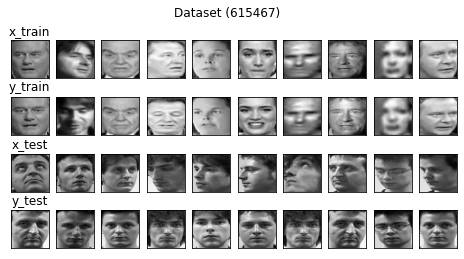

Epoch 1/148
256/256 [==============================] - ETA: 0s - loss: 0.0378
Epoch 00001: loss improved from inf to 0.03780, saving model to models/12/Model-v12.h5


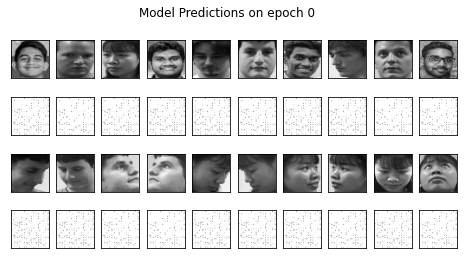

256/256 [==============================] - 301s 1s/step - loss: 0.0378 - val_loss: 0.0339
Epoch 2/148
256/256 [==============================] - ETA: 0s - loss: 0.0325
Epoch 00002: loss improved from 0.03780 to 0.03253, saving model to models/12/Model-v12.h5


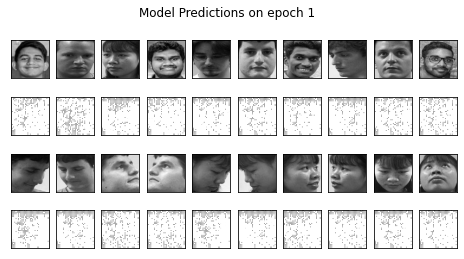

256/256 [==============================] - 282s 1s/step - loss: 0.0325 - val_loss: 0.0334
Epoch 3/148
256/256 [==============================] - ETA: 0s - loss: 0.0319
Epoch 00003: loss improved from 0.03253 to 0.03191, saving model to models/12/Model-v12.h5


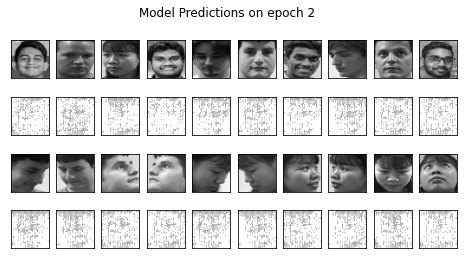

256/256 [==============================] - 280s 1s/step - loss: 0.0319 - val_loss: 0.0328
Epoch 4/148
256/256 [==============================] - ETA: 0s - loss: 0.0317
Epoch 00004: loss improved from 0.03191 to 0.03168, saving model to models/12/Model-v12.h5


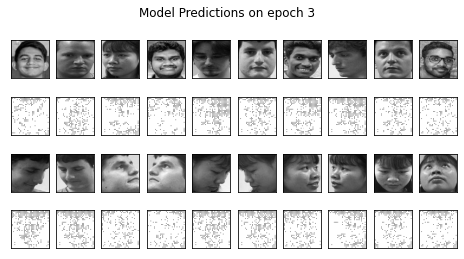

256/256 [==============================] - 280s 1s/step - loss: 0.0317 - val_loss: 0.0333
Epoch 5/148
256/256 [==============================] - ETA: 0s - loss: 0.0311
Epoch 00005: loss improved from 0.03168 to 0.03115, saving model to models/12/Model-v12.h5


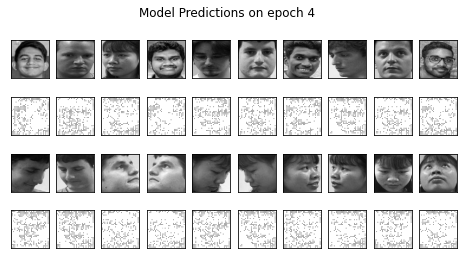

256/256 [==============================] - 280s 1s/step - loss: 0.0311 - val_loss: 0.0335
Epoch 6/148
256/256 [==============================] - ETA: 0s - loss: 0.0311
Epoch 00006: loss improved from 0.03115 to 0.03111, saving model to models/12/Model-v12.h5


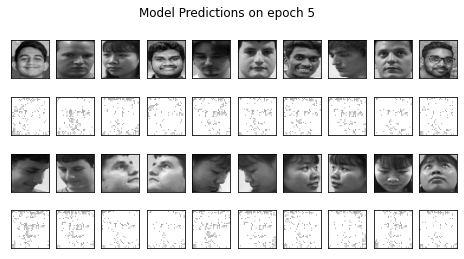

256/256 [==============================] - 278s 1s/step - loss: 0.0311 - val_loss: 0.0357
Epoch 7/148
256/256 [==============================] - ETA: 0s - loss: 0.0312
Epoch 00007: loss did not improve from 0.03111


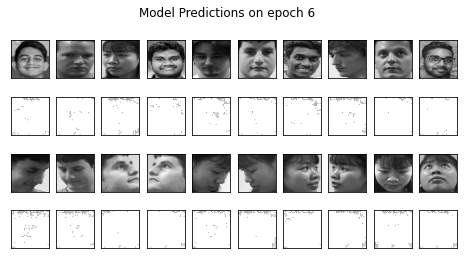

256/256 [==============================] - 278s 1s/step - loss: 0.0312 - val_loss: 0.0351
Epoch 8/148
256/256 [==============================] - ETA: 0s - loss: 0.0306
Epoch 00008: loss improved from 0.03111 to 0.03062, saving model to models/12/Model-v12.h5


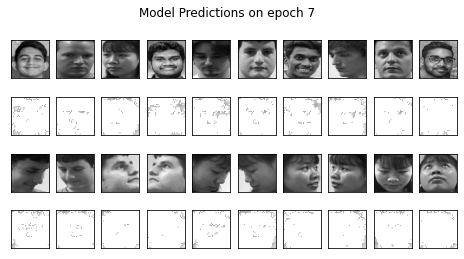

256/256 [==============================] - 279s 1s/step - loss: 0.0306 - val_loss: 0.0330
Epoch 9/148
256/256 [==============================] - ETA: 0s - loss: 0.0308
Epoch 00009: loss did not improve from 0.03062


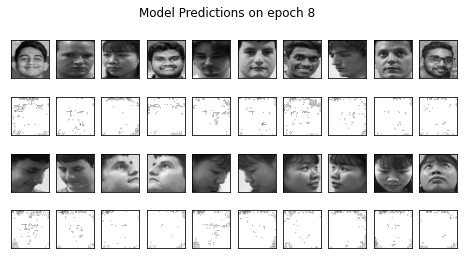

256/256 [==============================] - 279s 1s/step - loss: 0.0308 - val_loss: 0.0331
Epoch 10/148
256/256 [==============================] - ETA: 0s - loss: 0.0304
Epoch 00010: loss improved from 0.03062 to 0.03045, saving model to models/12/Model-v12.h5


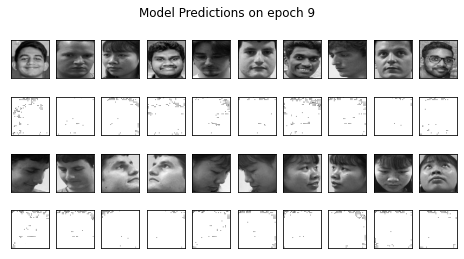

256/256 [==============================] - 278s 1s/step - loss: 0.0304 - val_loss: 0.0337
Epoch 11/148
256/256 [==============================] - ETA: 0s - loss: 0.0307
Epoch 00011: loss did not improve from 0.03045


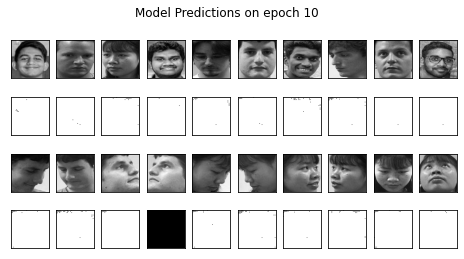

256/256 [==============================] - 279s 1s/step - loss: 0.0307 - val_loss: 0.0347
Epoch 12/148
256/256 [==============================] - ETA: 0s - loss: 0.0305
Epoch 00012: loss did not improve from 0.03045


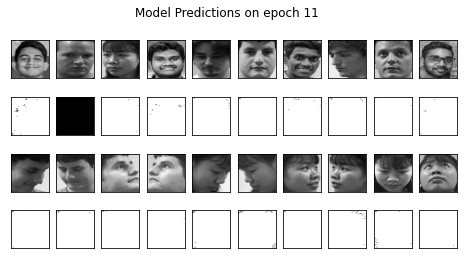

256/256 [==============================] - 279s 1s/step - loss: 0.0305 - val_loss: 0.0341
Epoch 13/148
256/256 [==============================] - ETA: 0s - loss: 0.0309
Epoch 00013: loss did not improve from 0.03045


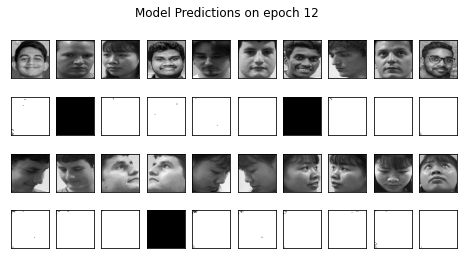

256/256 [==============================] - 279s 1s/step - loss: 0.0309 - val_loss: 0.0350
Epoch 14/148
256/256 [==============================] - ETA: 0s - loss: 0.0304
Epoch 00014: loss improved from 0.03045 to 0.03037, saving model to models/12/Model-v12.h5


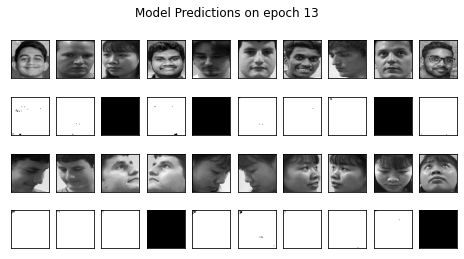

256/256 [==============================] - 279s 1s/step - loss: 0.0304 - val_loss: 0.0353
Epoch 15/148
256/256 [==============================] - ETA: 0s - loss: 0.0306
Epoch 00015: loss did not improve from 0.03037


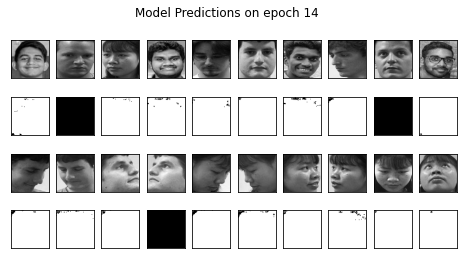

256/256 [==============================] - 279s 1s/step - loss: 0.0306 - val_loss: 0.0331
Epoch 16/148
256/256 [==============================] - ETA: 0s - loss: 0.0301
Epoch 00016: loss improved from 0.03037 to 0.03009, saving model to models/12/Model-v12.h5


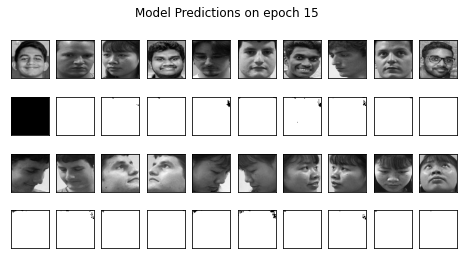

256/256 [==============================] - 278s 1s/step - loss: 0.0301 - val_loss: 0.0342
Epoch 17/148
256/256 [==============================] - ETA: 0s - loss: 0.0303
Epoch 00017: loss did not improve from 0.03009


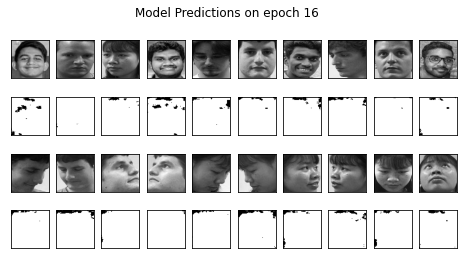

256/256 [==============================] - 279s 1s/step - loss: 0.0303 - val_loss: 0.0346
Epoch 18/148
256/256 [==============================] - ETA: 0s - loss: 0.0300
Epoch 00018: loss improved from 0.03009 to 0.03004, saving model to models/12/Model-v12.h5


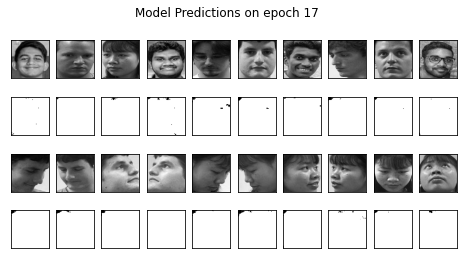

256/256 [==============================] - 279s 1s/step - loss: 0.0300 - val_loss: 0.0339
Epoch 19/148
256/256 [==============================] - ETA: 0s - loss: 0.0301
Epoch 00019: loss did not improve from 0.03004


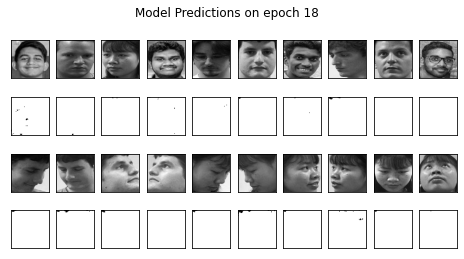

256/256 [==============================] - 279s 1s/step - loss: 0.0301 - val_loss: 0.0367
Epoch 20/148
256/256 [==============================] - ETA: 0s - loss: 0.0301
Epoch 00020: loss did not improve from 0.03004


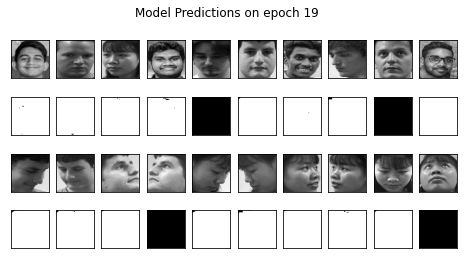

256/256 [==============================] - 279s 1s/step - loss: 0.0301 - val_loss: 0.0354
Epoch 21/148
256/256 [==============================] - ETA: 0s - loss: 0.0301
Epoch 00021: loss did not improve from 0.03004


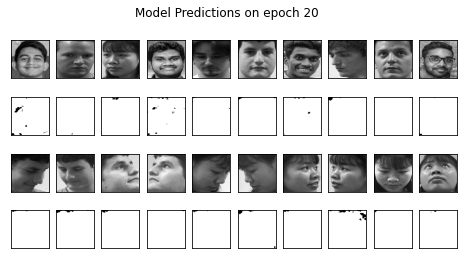

256/256 [==============================] - 279s 1s/step - loss: 0.0301 - val_loss: 0.0347
Epoch 22/148
256/256 [==============================] - ETA: 0s - loss: 0.0298
Epoch 00022: loss improved from 0.03004 to 0.02976, saving model to models/12/Model-v12.h5


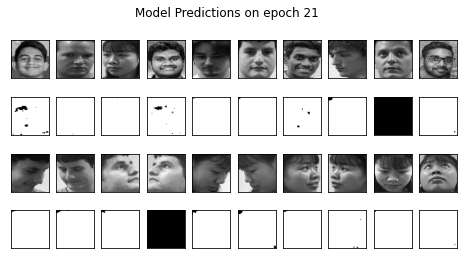

256/256 [==============================] - 279s 1s/step - loss: 0.0298 - val_loss: 0.0341
Epoch 23/148
256/256 [==============================] - ETA: 0s - loss: 0.0297
Epoch 00023: loss improved from 0.02976 to 0.02969, saving model to models/12/Model-v12.h5


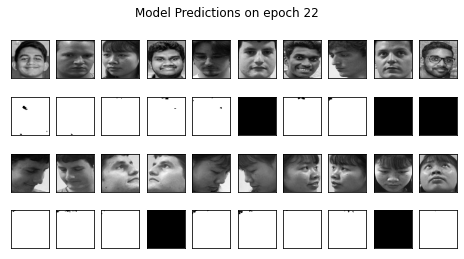

256/256 [==============================] - 279s 1s/step - loss: 0.0297 - val_loss: 0.0342
Epoch 24/148
256/256 [==============================] - ETA: 0s - loss: 0.0297
Epoch 00024: loss improved from 0.02969 to 0.02967, saving model to models/12/Model-v12.h5


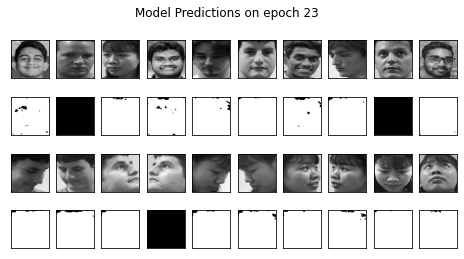

256/256 [==============================] - 280s 1s/step - loss: 0.0297 - val_loss: 0.0339
Epoch 25/148
256/256 [==============================] - ETA: 0s - loss: 0.0296
Epoch 00025: loss improved from 0.02967 to 0.02958, saving model to models/12/Model-v12.h5


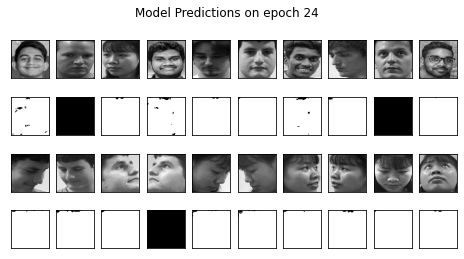

256/256 [==============================] - 279s 1s/step - loss: 0.0296 - val_loss: 0.0347
Epoch 26/148
256/256 [==============================] - ETA: 0s - loss: 0.0299
Epoch 00026: loss did not improve from 0.02958


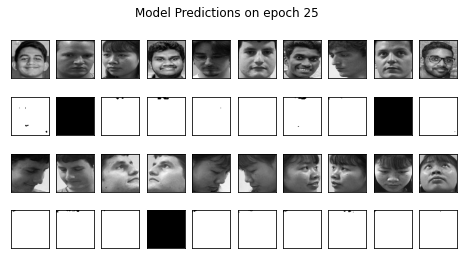

256/256 [==============================] - 279s 1s/step - loss: 0.0299 - val_loss: 0.0343
Epoch 27/148
256/256 [==============================] - ETA: 0s - loss: 0.0296
Epoch 00027: loss did not improve from 0.02958


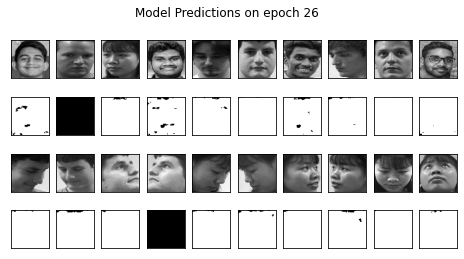

256/256 [==============================] - 279s 1s/step - loss: 0.0296 - val_loss: 0.0338
Epoch 28/148
256/256 [==============================] - ETA: 0s - loss: 0.0298
Epoch 00028: loss did not improve from 0.02958


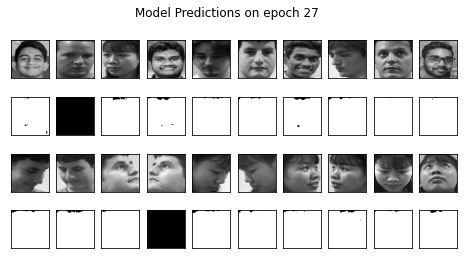

256/256 [==============================] - 279s 1s/step - loss: 0.0298 - val_loss: 0.0342
Epoch 29/148
256/256 [==============================] - ETA: 0s - loss: 0.0294
Epoch 00029: loss improved from 0.02958 to 0.02938, saving model to models/12/Model-v12.h5


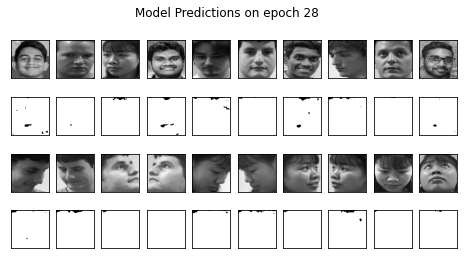

256/256 [==============================] - 278s 1s/step - loss: 0.0294 - val_loss: 0.0338
Epoch 30/148
256/256 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00030: loss did not improve from 0.02938


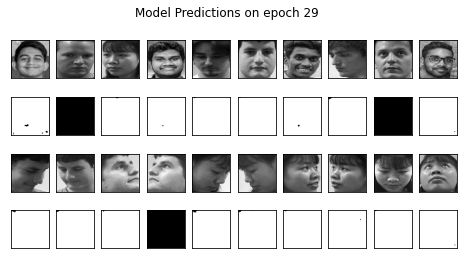

256/256 [==============================] - 278s 1s/step - loss: 0.0295 - val_loss: 0.0345
Epoch 31/148
256/256 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00031: loss did not improve from 0.02938


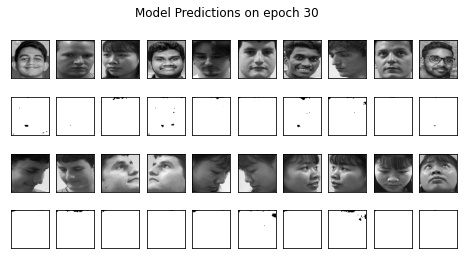

256/256 [==============================] - 279s 1s/step - loss: 0.0295 - val_loss: 0.0345
Epoch 32/148
256/256 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00032: loss did not improve from 0.02938


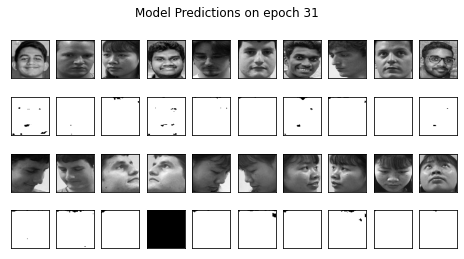

256/256 [==============================] - 278s 1s/step - loss: 0.0295 - val_loss: 0.0335
Epoch 33/148
256/256 [==============================] - ETA: 0s - loss: 0.0294
Epoch 00033: loss did not improve from 0.02938


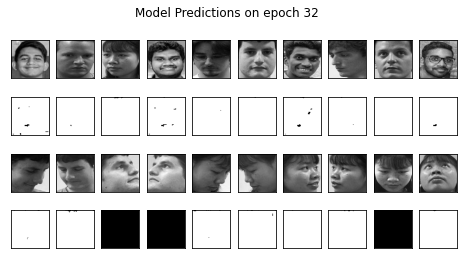

256/256 [==============================] - 279s 1s/step - loss: 0.0294 - val_loss: 0.0344
Epoch 34/148
256/256 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00034: loss did not improve from 0.02938


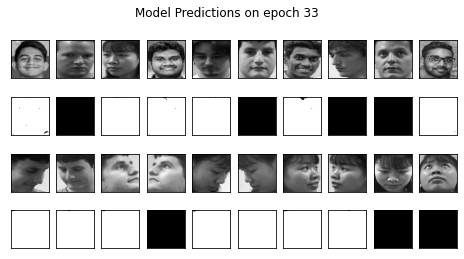

256/256 [==============================] - 278s 1s/step - loss: 0.0295 - val_loss: 0.0343
Epoch 35/148
256/256 [==============================] - ETA: 0s - loss: 0.0295
Epoch 00035: loss did not improve from 0.02938


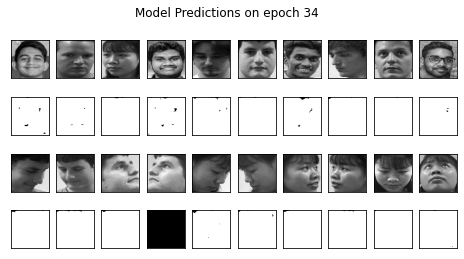

256/256 [==============================] - 277s 1s/step - loss: 0.0295 - val_loss: 0.0341
Epoch 36/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00036: loss improved from 0.02938 to 0.02911, saving model to models/12/Model-v12.h5


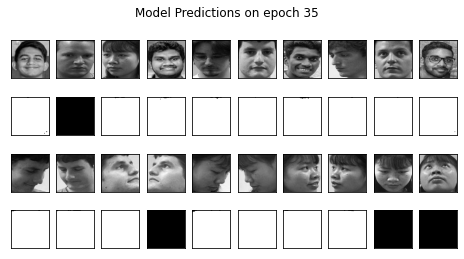

256/256 [==============================] - 279s 1s/step - loss: 0.0291 - val_loss: 0.0340
Epoch 37/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00037: loss improved from 0.02911 to 0.02909, saving model to models/12/Model-v12.h5


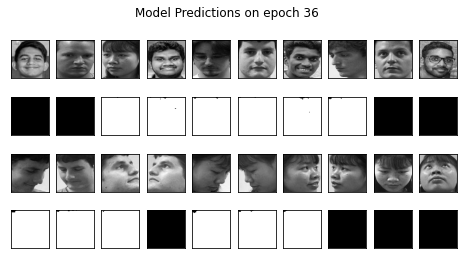

256/256 [==============================] - 279s 1s/step - loss: 0.0291 - val_loss: 0.0340
Epoch 38/148
256/256 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00038: loss did not improve from 0.02909


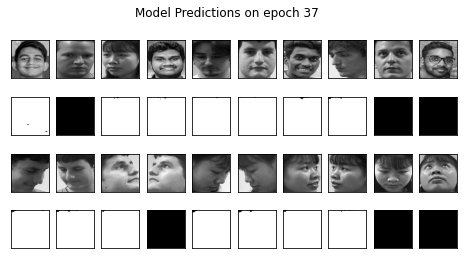

256/256 [==============================] - 277s 1s/step - loss: 0.0292 - val_loss: 0.0344
Epoch 39/148
256/256 [==============================] - ETA: 0s - loss: 0.0294
Epoch 00039: loss did not improve from 0.02909


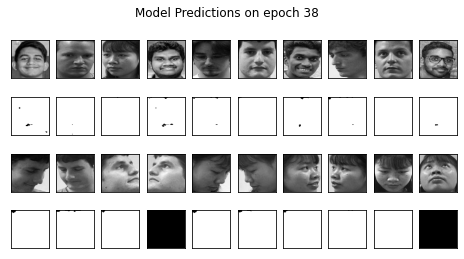

256/256 [==============================] - 263s 1s/step - loss: 0.0294 - val_loss: 0.0340
Epoch 40/148
256/256 [==============================] - ETA: 0s - loss: 0.0293
Epoch 00040: loss did not improve from 0.02909


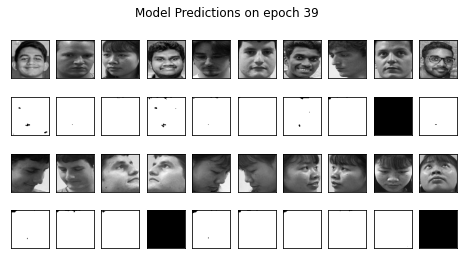

256/256 [==============================] - 263s 1s/step - loss: 0.0293 - val_loss: 0.0341
Epoch 41/148
256/256 [==============================] - ETA: 0s - loss: 0.0294
Epoch 00041: loss did not improve from 0.02909


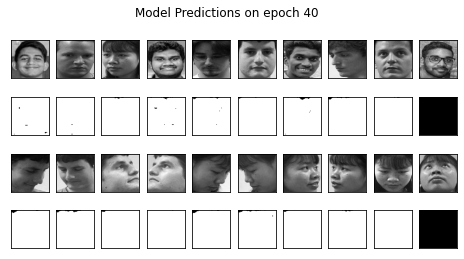

256/256 [==============================] - 263s 1s/step - loss: 0.0294 - val_loss: 0.0342
Epoch 42/148
256/256 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00042: loss did not improve from 0.02909


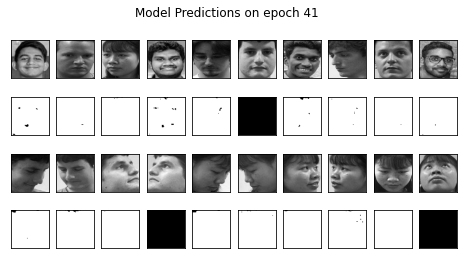

256/256 [==============================] - 263s 1s/step - loss: 0.0292 - val_loss: 0.0336
Epoch 43/148
256/256 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00043: loss did not improve from 0.02909


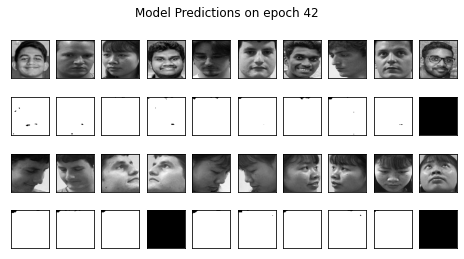

256/256 [==============================] - 263s 1s/step - loss: 0.0292 - val_loss: 0.0341
Epoch 44/148
256/256 [==============================] - ETA: 0s - loss: 0.0293
Epoch 00044: loss did not improve from 0.02909


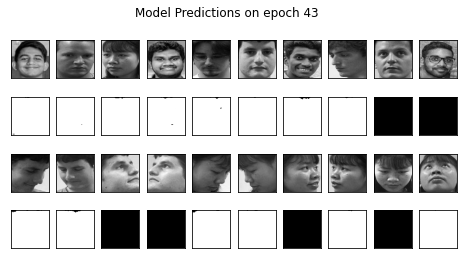

256/256 [==============================] - 263s 1s/step - loss: 0.0293 - val_loss: 0.0339
Epoch 45/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00045: loss improved from 0.02909 to 0.02906, saving model to models/12/Model-v12.h5


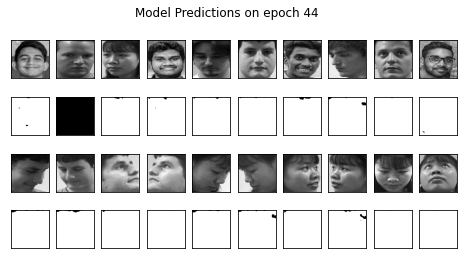

256/256 [==============================] - 264s 1s/step - loss: 0.0291 - val_loss: 0.0337
Epoch 46/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00046: loss did not improve from 0.02906


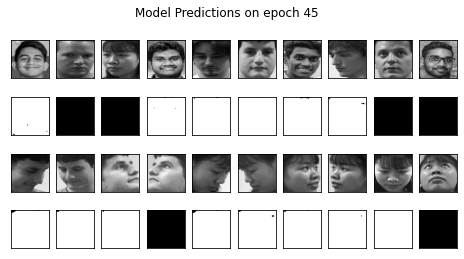

256/256 [==============================] - 264s 1s/step - loss: 0.0291 - val_loss: 0.0345
Epoch 47/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00047: loss improved from 0.02906 to 0.02877, saving model to models/12/Model-v12.h5


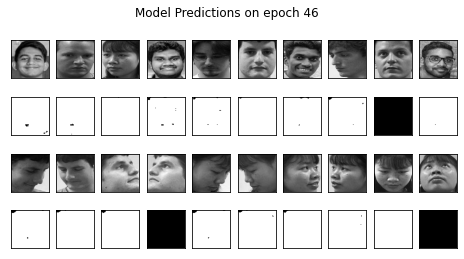

256/256 [==============================] - 264s 1s/step - loss: 0.0288 - val_loss: 0.0339
Epoch 48/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00048: loss did not improve from 0.02877


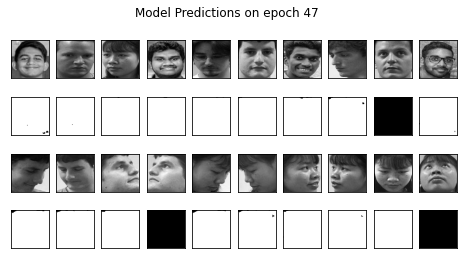

256/256 [==============================] - 263s 1s/step - loss: 0.0290 - val_loss: 0.0342
Epoch 49/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00049: loss improved from 0.02877 to 0.02874, saving model to models/12/Model-v12.h5


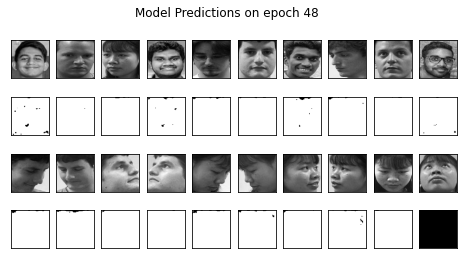

256/256 [==============================] - 264s 1s/step - loss: 0.0287 - val_loss: 0.0336
Epoch 50/148
256/256 [==============================] - ETA: 0s - loss: 0.0293
Epoch 00050: loss did not improve from 0.02874


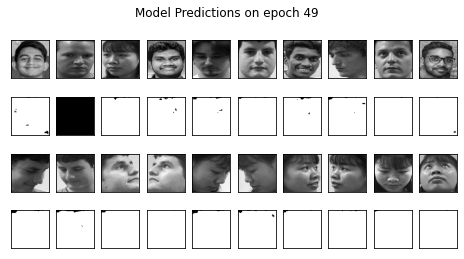

256/256 [==============================] - 264s 1s/step - loss: 0.0293 - val_loss: 0.0339
Epoch 51/148
256/256 [==============================] - ETA: 0s - loss: 0.0293
Epoch 00051: loss did not improve from 0.02874


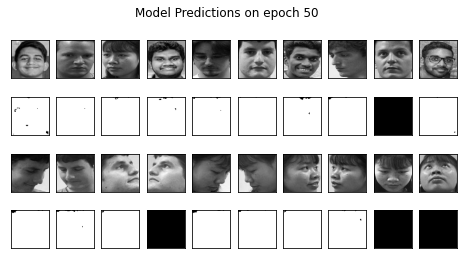

256/256 [==============================] - 263s 1s/step - loss: 0.0293 - val_loss: 0.0338
Epoch 52/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00052: loss did not improve from 0.02874


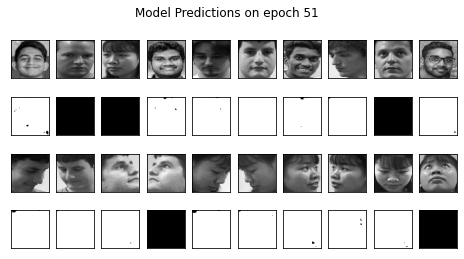

256/256 [==============================] - 263s 1s/step - loss: 0.0290 - val_loss: 0.0338
Epoch 53/148
256/256 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00053: loss did not improve from 0.02874


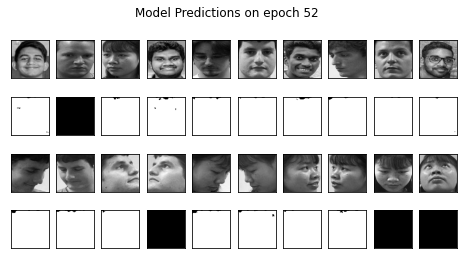

256/256 [==============================] - 263s 1s/step - loss: 0.0292 - val_loss: 0.0336
Epoch 54/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00054: loss improved from 0.02874 to 0.02862, saving model to models/12/Model-v12.h5


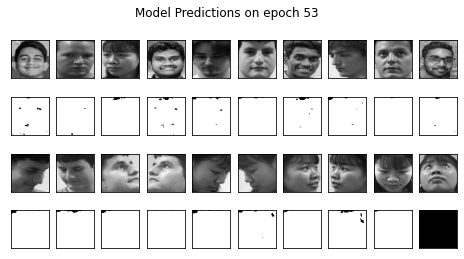

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0342
Epoch 55/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00055: loss did not improve from 0.02862


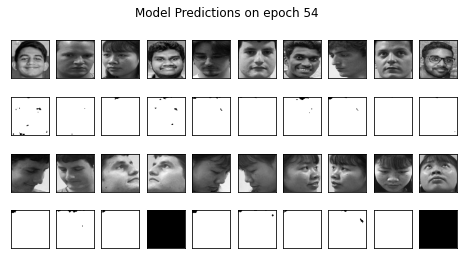

256/256 [==============================] - 263s 1s/step - loss: 0.0290 - val_loss: 0.0334
Epoch 56/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00056: loss did not improve from 0.02862


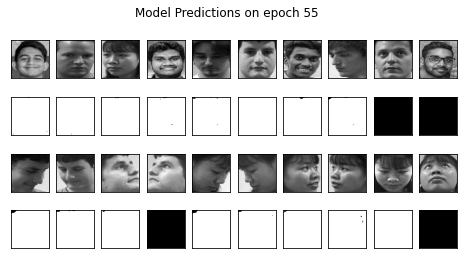

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0341
Epoch 57/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00057: loss did not improve from 0.02862


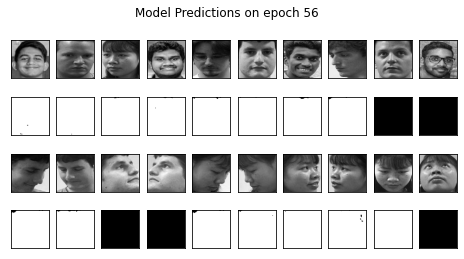

256/256 [==============================] - 263s 1s/step - loss: 0.0291 - val_loss: 0.0346
Epoch 58/148
256/256 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00058: loss did not improve from 0.02862


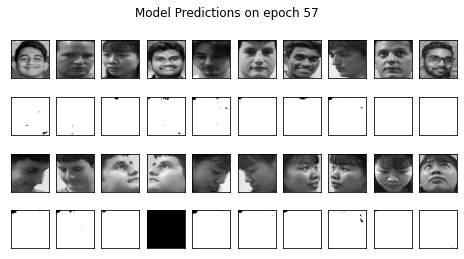

256/256 [==============================] - 263s 1s/step - loss: 0.0292 - val_loss: 0.0339
Epoch 59/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00059: loss did not improve from 0.02862


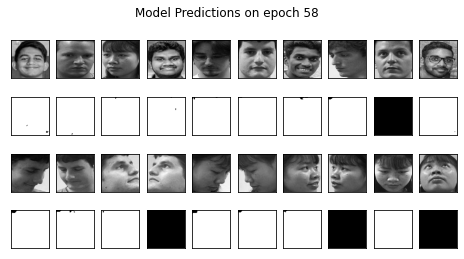

256/256 [==============================] - 264s 1s/step - loss: 0.0288 - val_loss: 0.0347
Epoch 60/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00060: loss did not improve from 0.02862


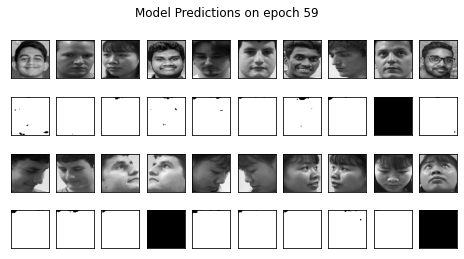

256/256 [==============================] - 263s 1s/step - loss: 0.0288 - val_loss: 0.0333
Epoch 61/148
256/256 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00061: loss did not improve from 0.02862


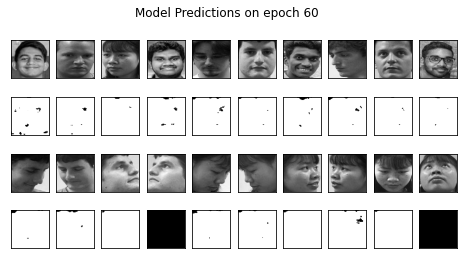

256/256 [==============================] - 263s 1s/step - loss: 0.0289 - val_loss: 0.0338
Epoch 62/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00062: loss improved from 0.02862 to 0.02845, saving model to models/12/Model-v12.h5


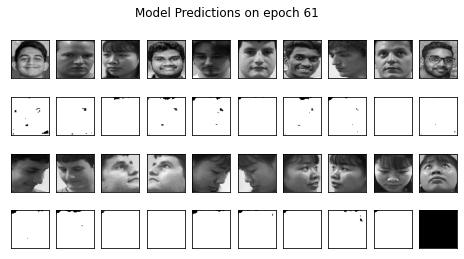

256/256 [==============================] - 265s 1s/step - loss: 0.0284 - val_loss: 0.0340
Epoch 63/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00063: loss did not improve from 0.02845


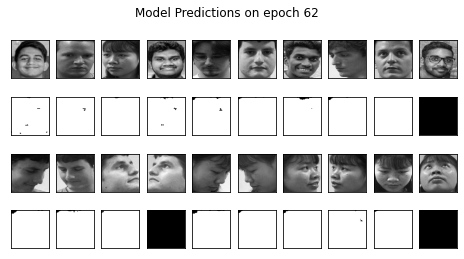

256/256 [==============================] - 264s 1s/step - loss: 0.0287 - val_loss: 0.0341
Epoch 64/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00064: loss did not improve from 0.02845


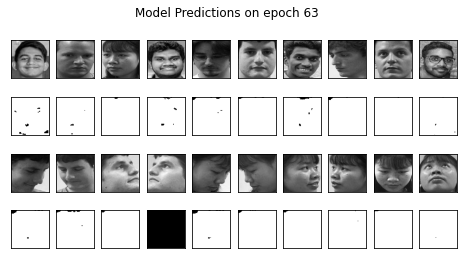

256/256 [==============================] - 263s 1s/step - loss: 0.0290 - val_loss: 0.0346
Epoch 65/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00065: loss did not improve from 0.02845


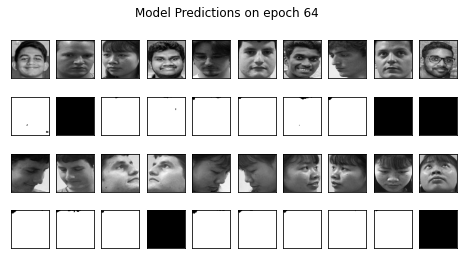

256/256 [==============================] - 264s 1s/step - loss: 0.0290 - val_loss: 0.0341
Epoch 66/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00066: loss did not improve from 0.02845


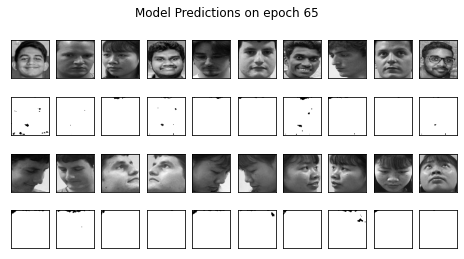

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0341
Epoch 67/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00067: loss did not improve from 0.02845


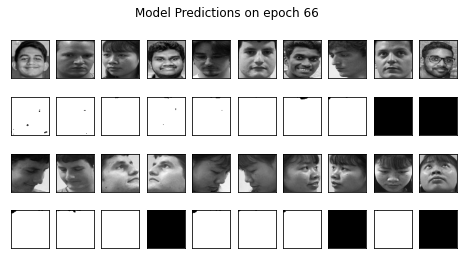

256/256 [==============================] - 264s 1s/step - loss: 0.0287 - val_loss: 0.0347
Epoch 68/148
256/256 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00068: loss did not improve from 0.02845


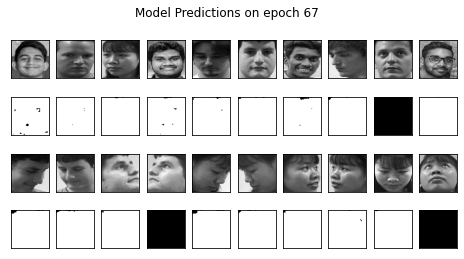

256/256 [==============================] - 264s 1s/step - loss: 0.0289 - val_loss: 0.0337
Epoch 69/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00069: loss did not improve from 0.02845


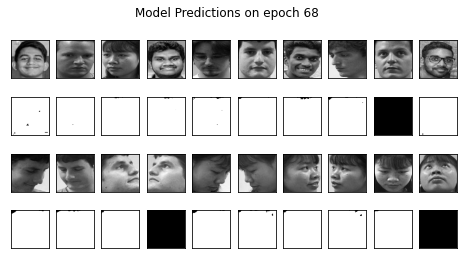

256/256 [==============================] - 263s 1s/step - loss: 0.0286 - val_loss: 0.0339
Epoch 70/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00070: loss did not improve from 0.02845


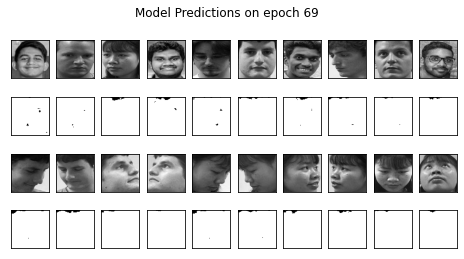

256/256 [==============================] - 264s 1s/step - loss: 0.0287 - val_loss: 0.0339
Epoch 71/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00071: loss did not improve from 0.02845


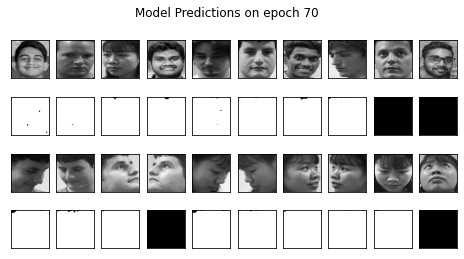

256/256 [==============================] - 264s 1s/step - loss: 0.0288 - val_loss: 0.0342
Epoch 72/148
256/256 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00072: loss did not improve from 0.02845


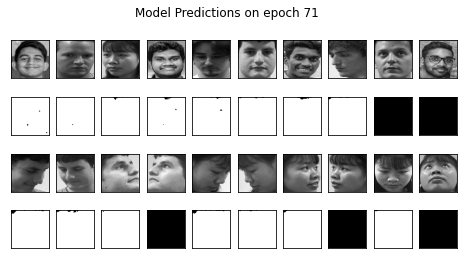

256/256 [==============================] - 264s 1s/step - loss: 0.0289 - val_loss: 0.0342
Epoch 73/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00073: loss did not improve from 0.02845


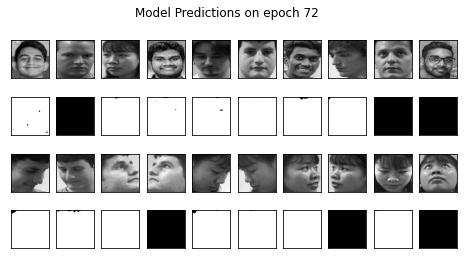

256/256 [==============================] - 263s 1s/step - loss: 0.0288 - val_loss: 0.0341
Epoch 74/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00074: loss improved from 0.02845 to 0.02842, saving model to models/12/Model-v12.h5


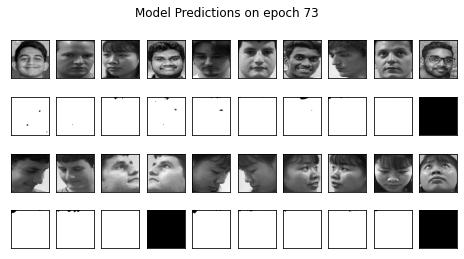

256/256 [==============================] - 265s 1s/step - loss: 0.0284 - val_loss: 0.0341
Epoch 75/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00075: loss did not improve from 0.02842


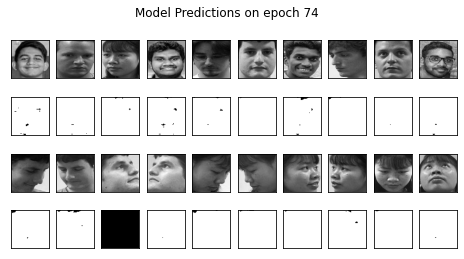

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0341
Epoch 76/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00076: loss did not improve from 0.02842


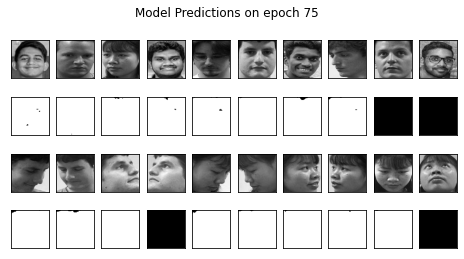

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0340
Epoch 77/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00077: loss did not improve from 0.02842


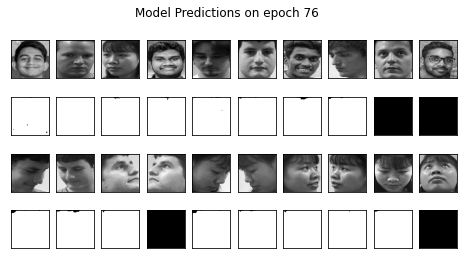

256/256 [==============================] - 264s 1s/step - loss: 0.0287 - val_loss: 0.0344
Epoch 78/148
256/256 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00078: loss did not improve from 0.02842


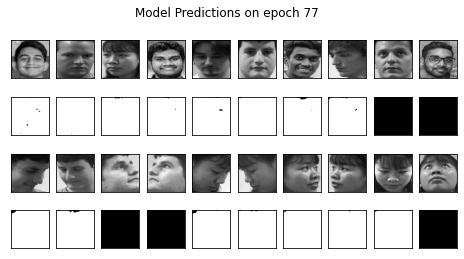

256/256 [==============================] - 264s 1s/step - loss: 0.0289 - val_loss: 0.0342
Epoch 79/148
256/256 [==============================] - ETA: 0s - loss: 0.0289
Epoch 00079: loss did not improve from 0.02842


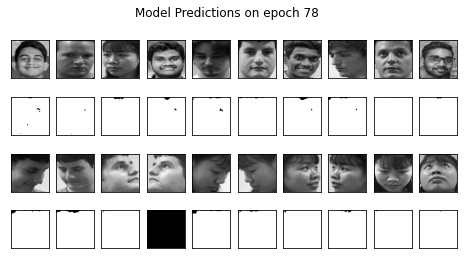

256/256 [==============================] - 263s 1s/step - loss: 0.0289 - val_loss: 0.0346
Epoch 80/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00080: loss did not improve from 0.02842


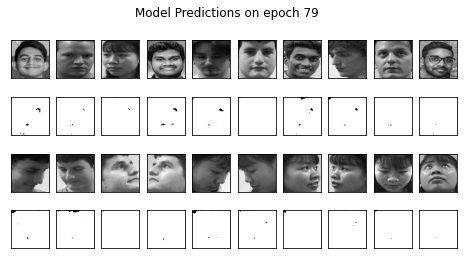

256/256 [==============================] - 263s 1s/step - loss: 0.0286 - val_loss: 0.0339
Epoch 81/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00081: loss did not improve from 0.02842


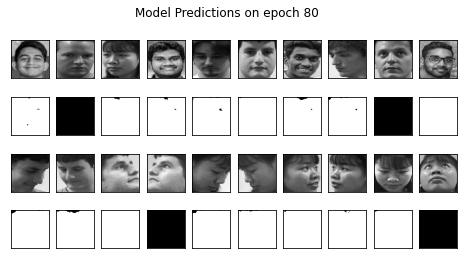

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0337
Epoch 82/148
256/256 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00082: loss did not improve from 0.02842


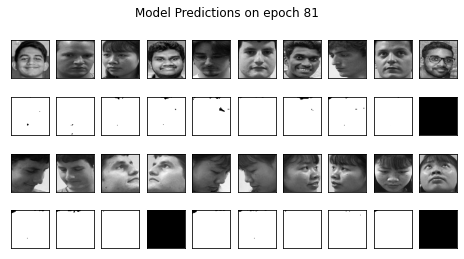

256/256 [==============================] - 263s 1s/step - loss: 0.0290 - val_loss: 0.0341
Epoch 83/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00083: loss improved from 0.02842 to 0.02832, saving model to models/12/Model-v12.h5


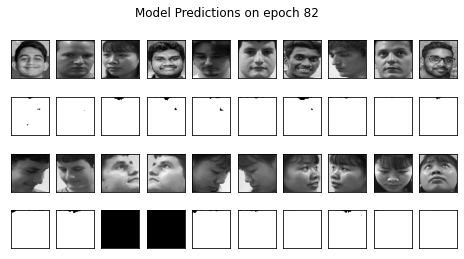

256/256 [==============================] - 263s 1s/step - loss: 0.0283 - val_loss: 0.0342
Epoch 84/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00084: loss did not improve from 0.02832


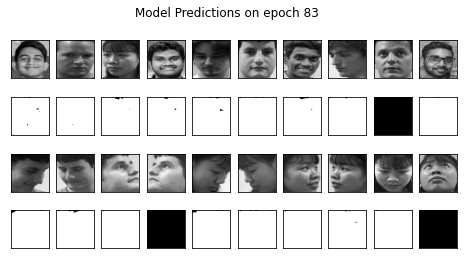

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0338
Epoch 85/148
256/256 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00085: loss improved from 0.02832 to 0.02811, saving model to models/12/Model-v12.h5


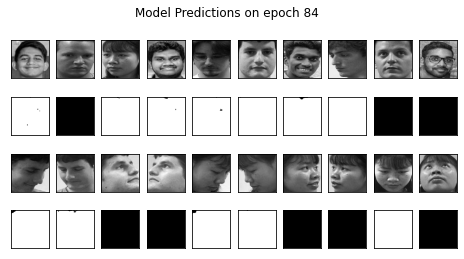

256/256 [==============================] - 263s 1s/step - loss: 0.0281 - val_loss: 0.0341
Epoch 86/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00086: loss did not improve from 0.02811


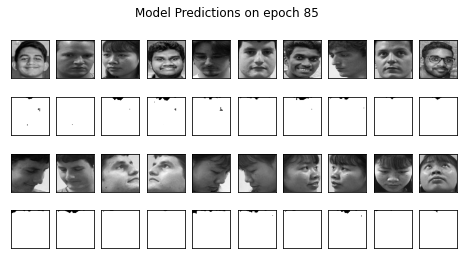

256/256 [==============================] - 262s 1s/step - loss: 0.0287 - val_loss: 0.0343
Epoch 87/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00087: loss did not improve from 0.02811


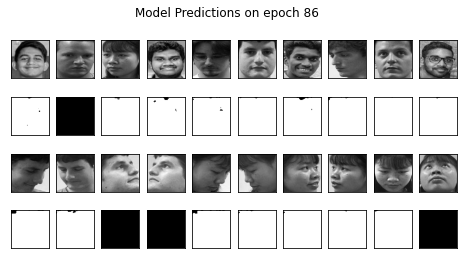

256/256 [==============================] - 262s 1s/step - loss: 0.0285 - val_loss: 0.0338
Epoch 88/148
256/256 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00088: loss did not improve from 0.02811


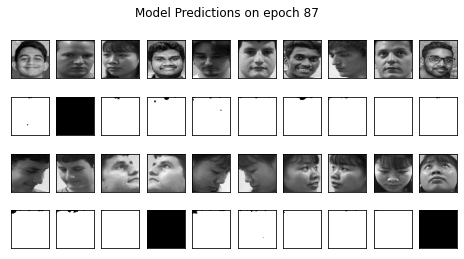

256/256 [==============================] - 263s 1s/step - loss: 0.0291 - val_loss: 0.0341
Epoch 89/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00089: loss did not improve from 0.02811


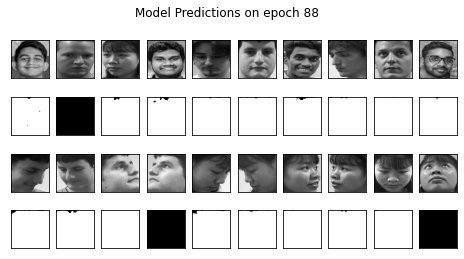

256/256 [==============================] - 263s 1s/step - loss: 0.0283 - val_loss: 0.0344
Epoch 90/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00090: loss did not improve from 0.02811


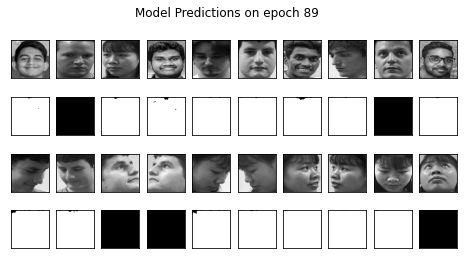

256/256 [==============================] - 262s 1s/step - loss: 0.0288 - val_loss: 0.0344
Epoch 91/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00091: loss did not improve from 0.02811


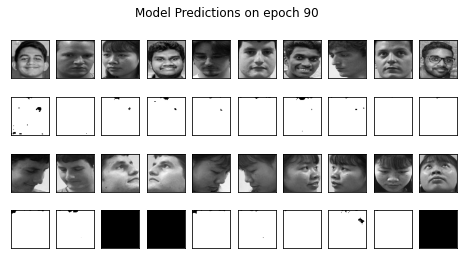

256/256 [==============================] - 264s 1s/step - loss: 0.0284 - val_loss: 0.0340
Epoch 92/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00092: loss did not improve from 0.02811


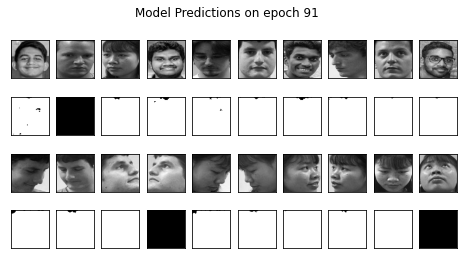

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0344
Epoch 93/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00093: loss did not improve from 0.02811


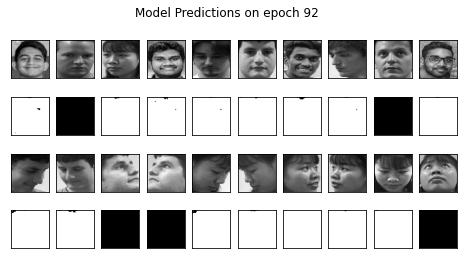

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0340
Epoch 94/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00094: loss did not improve from 0.02811


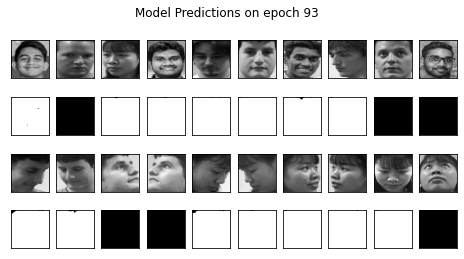

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0353
Epoch 95/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00095: loss did not improve from 0.02811


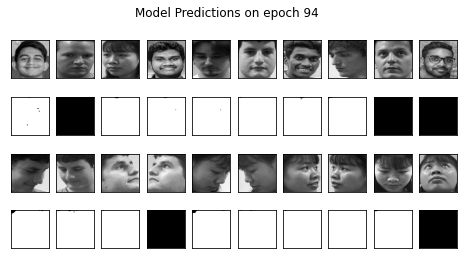

256/256 [==============================] - 263s 1s/step - loss: 0.0286 - val_loss: 0.0343
Epoch 96/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00096: loss did not improve from 0.02811


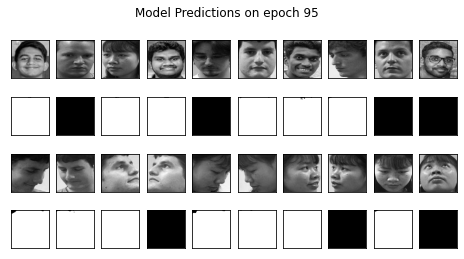

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0341
Epoch 97/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00097: loss did not improve from 0.02811


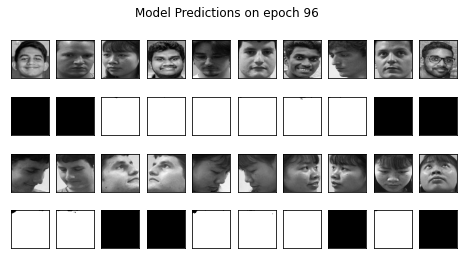

256/256 [==============================] - 264s 1s/step - loss: 0.0284 - val_loss: 0.0342
Epoch 98/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00098: loss did not improve from 0.02811


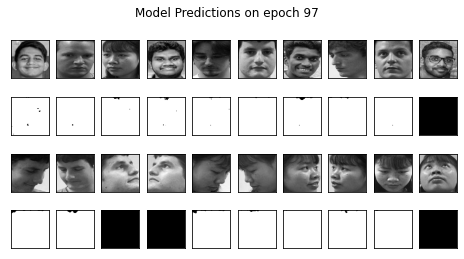

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0343
Epoch 99/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00099: loss did not improve from 0.02811


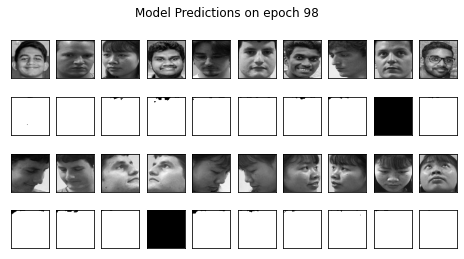

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0345
Epoch 100/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00100: loss did not improve from 0.02811


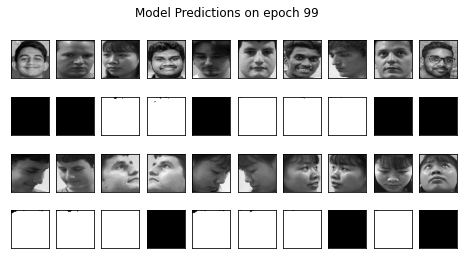

256/256 [==============================] - 264s 1s/step - loss: 0.0282 - val_loss: 0.0343
Epoch 101/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00101: loss did not improve from 0.02811


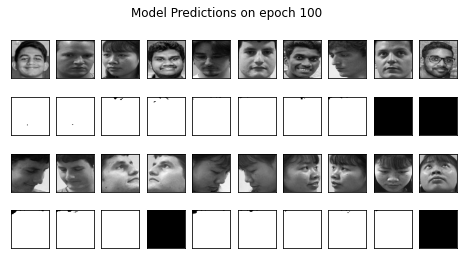

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0340
Epoch 102/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00102: loss did not improve from 0.02811


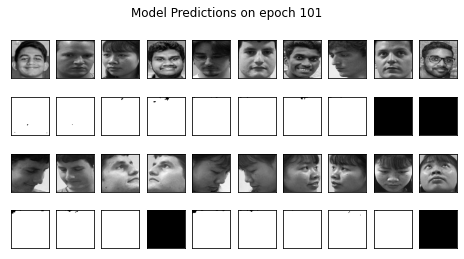

256/256 [==============================] - 263s 1s/step - loss: 0.0286 - val_loss: 0.0340
Epoch 103/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00103: loss did not improve from 0.02811


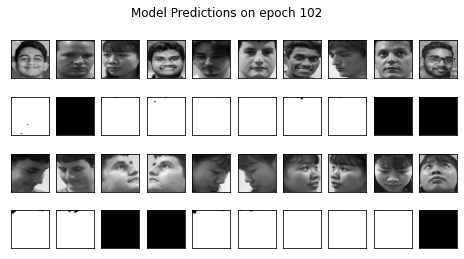

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0348
Epoch 104/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00104: loss did not improve from 0.02811


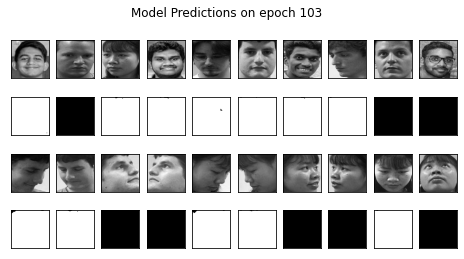

256/256 [==============================] - 263s 1s/step - loss: 0.0284 - val_loss: 0.0342
Epoch 105/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00105: loss did not improve from 0.02811


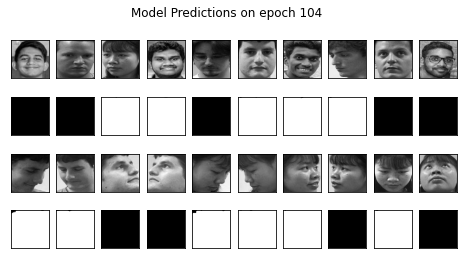

256/256 [==============================] - 264s 1s/step - loss: 0.0284 - val_loss: 0.0343
Epoch 106/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00106: loss did not improve from 0.02811


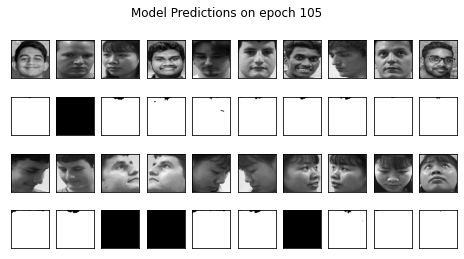

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0342
Epoch 107/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00107: loss did not improve from 0.02811


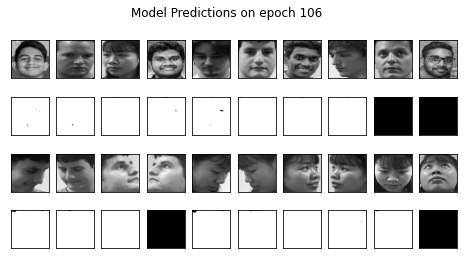

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0344
Epoch 108/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00108: loss did not improve from 0.02811


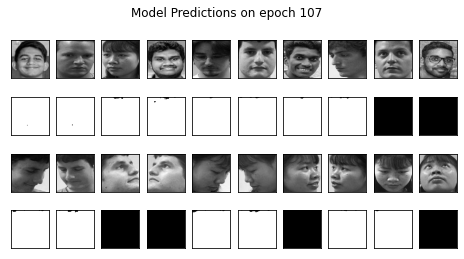

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0345
Epoch 109/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00109: loss did not improve from 0.02811


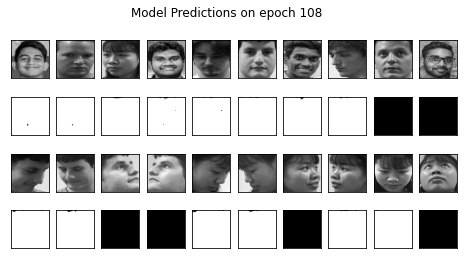

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0342
Epoch 110/148
256/256 [==============================] - ETA: 0s - loss: 0.0288
Epoch 00110: loss did not improve from 0.02811


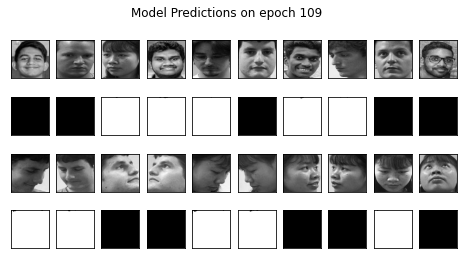

256/256 [==============================] - 263s 1s/step - loss: 0.0288 - val_loss: 0.0340
Epoch 111/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00111: loss did not improve from 0.02811


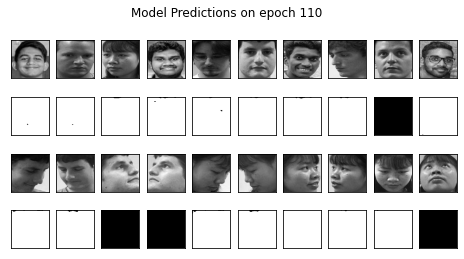

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0342
Epoch 112/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00112: loss did not improve from 0.02811


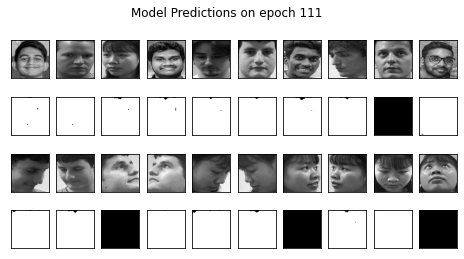

256/256 [==============================] - 263s 1s/step - loss: 0.0282 - val_loss: 0.0339
Epoch 113/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00113: loss did not improve from 0.02811


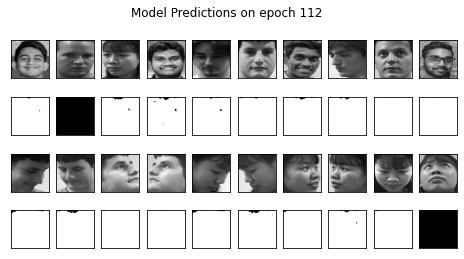

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0348
Epoch 114/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00114: loss did not improve from 0.02811


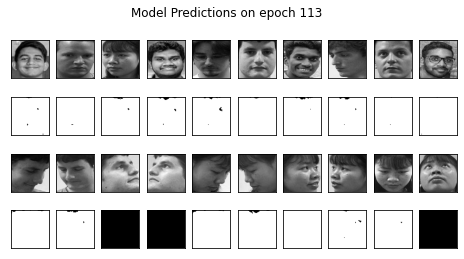

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0343
Epoch 115/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00115: loss did not improve from 0.02811


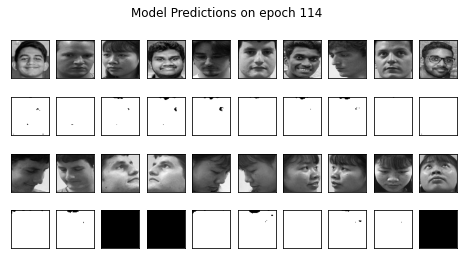

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0338
Epoch 116/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00116: loss did not improve from 0.02811


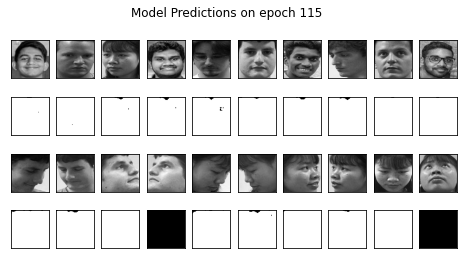

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0342
Epoch 117/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00117: loss did not improve from 0.02811


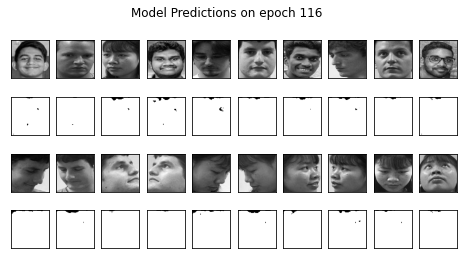

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0341
Epoch 118/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00118: loss did not improve from 0.02811


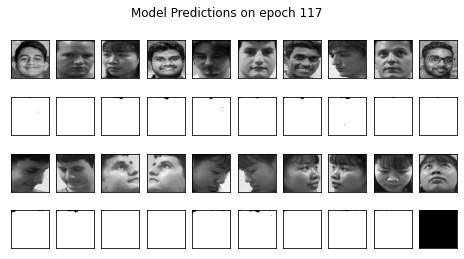

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0339
Epoch 119/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00119: loss did not improve from 0.02811


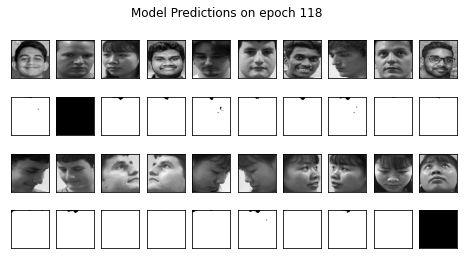

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0340
Epoch 120/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00120: loss did not improve from 0.02811


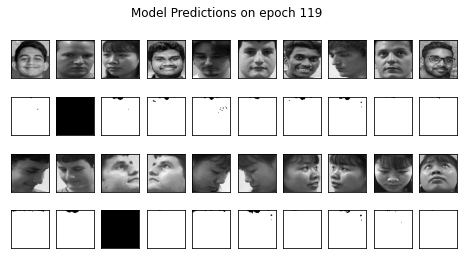

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0344
Epoch 121/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00121: loss did not improve from 0.02811


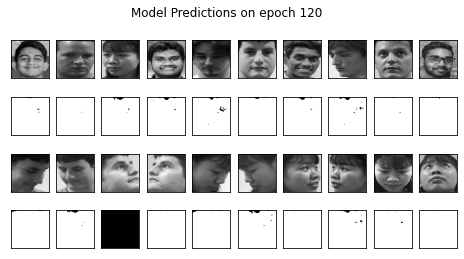

256/256 [==============================] - 264s 1s/step - loss: 0.0284 - val_loss: 0.0343
Epoch 122/148
256/256 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00122: loss did not improve from 0.02811


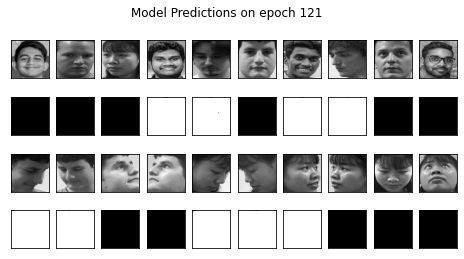

256/256 [==============================] - 263s 1s/step - loss: 0.0281 - val_loss: 0.0341
Epoch 123/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00123: loss did not improve from 0.02811


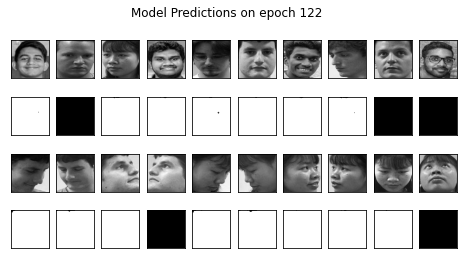

256/256 [==============================] - 263s 1s/step - loss: 0.0284 - val_loss: 0.0346
Epoch 124/148
256/256 [==============================] - ETA: 0s - loss: 0.0280
Epoch 00124: loss improved from 0.02811 to 0.02802, saving model to models/12/Model-v12.h5


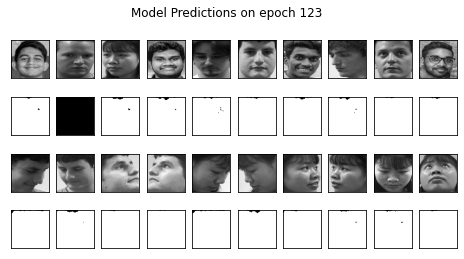

256/256 [==============================] - 264s 1s/step - loss: 0.0280 - val_loss: 0.0341
Epoch 125/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00125: loss did not improve from 0.02802


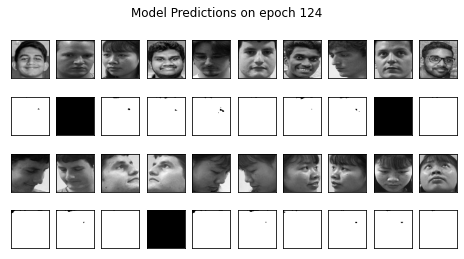

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0340
Epoch 126/148
256/256 [==============================] - ETA: 0s - loss: 0.0287
Epoch 00126: loss did not improve from 0.02802


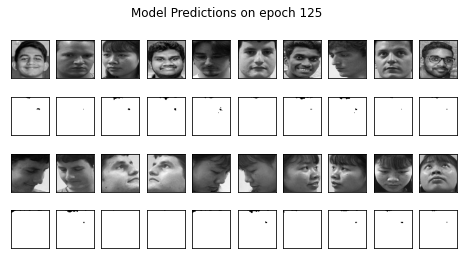

256/256 [==============================] - 263s 1s/step - loss: 0.0287 - val_loss: 0.0351
Epoch 127/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00127: loss did not improve from 0.02802


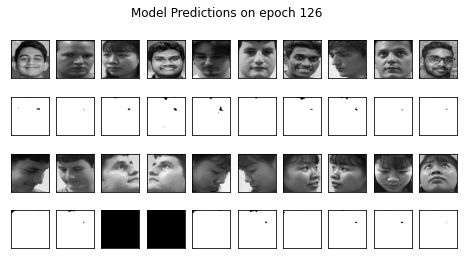

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0344
Epoch 128/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00128: loss did not improve from 0.02802


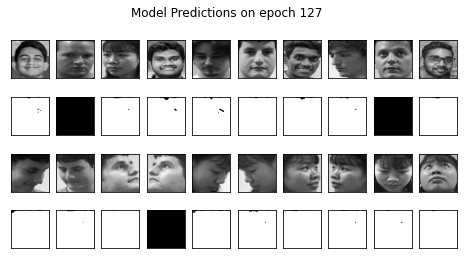

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0340
Epoch 129/148
256/256 [==============================] - ETA: 0s - loss: 0.0280
Epoch 00129: loss improved from 0.02802 to 0.02801, saving model to models/12/Model-v12.h5


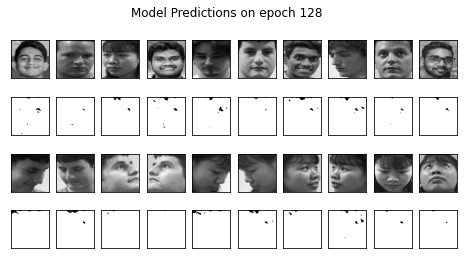

256/256 [==============================] - 264s 1s/step - loss: 0.0280 - val_loss: 0.0344
Epoch 130/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00130: loss did not improve from 0.02801


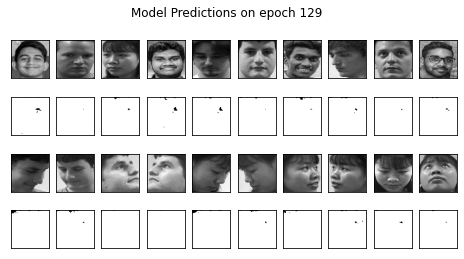

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0343
Epoch 131/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00131: loss did not improve from 0.02801


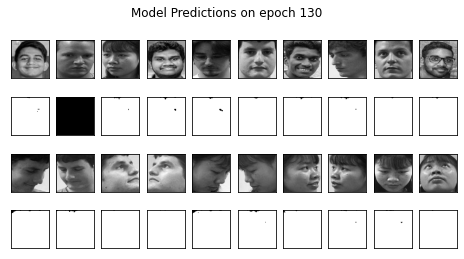

256/256 [==============================] - 263s 1s/step - loss: 0.0282 - val_loss: 0.0344
Epoch 132/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00132: loss did not improve from 0.02801


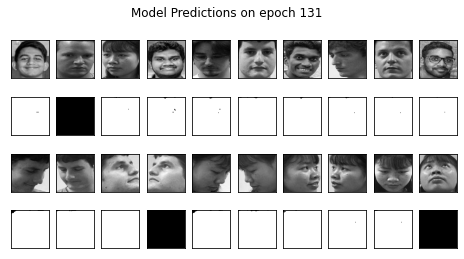

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0343
Epoch 133/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00133: loss did not improve from 0.02801


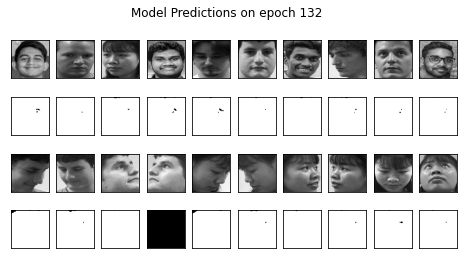

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0344
Epoch 134/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00134: loss did not improve from 0.02801


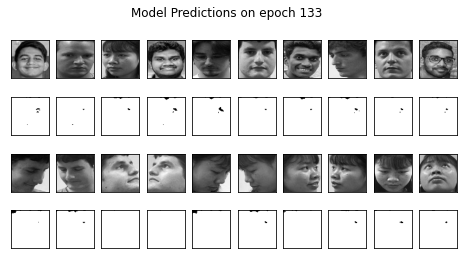

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0342
Epoch 135/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00135: loss did not improve from 0.02801


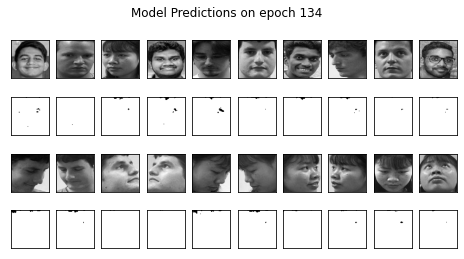

256/256 [==============================] - 264s 1s/step - loss: 0.0282 - val_loss: 0.0346
Epoch 136/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00136: loss did not improve from 0.02801


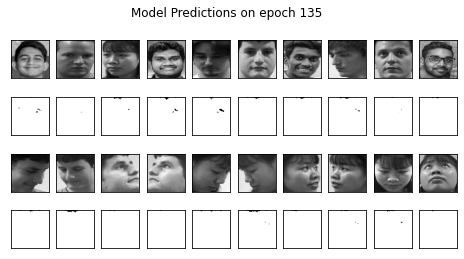

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0344
Epoch 137/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00137: loss did not improve from 0.02801


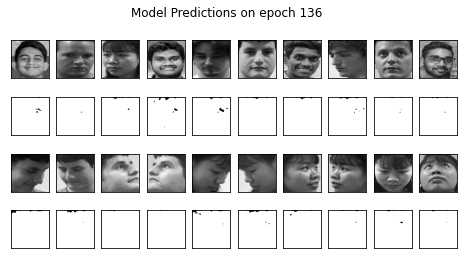

256/256 [==============================] - 263s 1s/step - loss: 0.0282 - val_loss: 0.0342
Epoch 138/148
256/256 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00138: loss did not improve from 0.02801


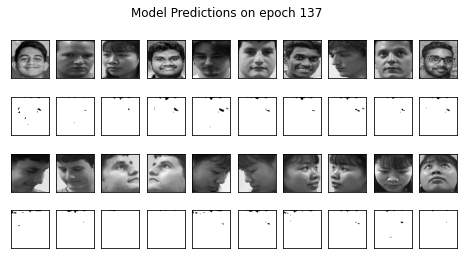

256/256 [==============================] - 263s 1s/step - loss: 0.0281 - val_loss: 0.0343
Epoch 139/148
256/256 [==============================] - ETA: 0s - loss: 0.0286
Epoch 00139: loss did not improve from 0.02801


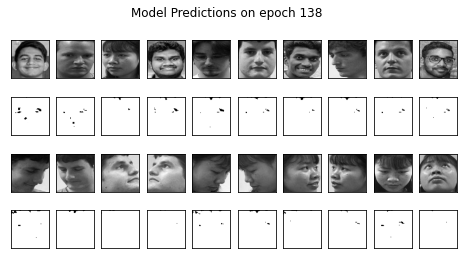

256/256 [==============================] - 264s 1s/step - loss: 0.0286 - val_loss: 0.0347
Epoch 140/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00140: loss did not improve from 0.02801


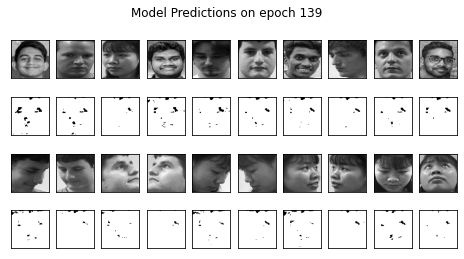

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0340
Epoch 141/148
256/256 [==============================] - ETA: 0s - loss: 0.0283
Epoch 00141: loss did not improve from 0.02801


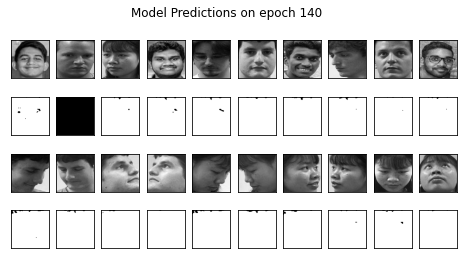

256/256 [==============================] - 264s 1s/step - loss: 0.0283 - val_loss: 0.0342
Epoch 142/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00142: loss did not improve from 0.02801


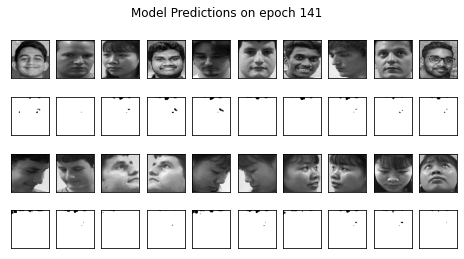

256/256 [==============================] - 264s 1s/step - loss: 0.0282 - val_loss: 0.0347
Epoch 143/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00143: loss did not improve from 0.02801


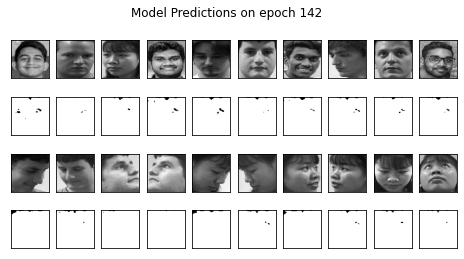

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0339
Epoch 144/148
256/256 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00144: loss did not improve from 0.02801


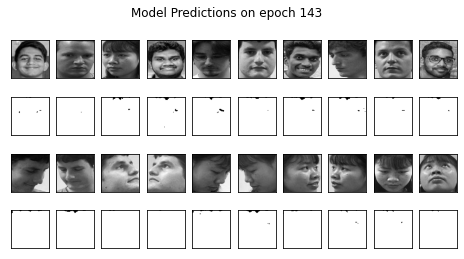

256/256 [==============================] - 264s 1s/step - loss: 0.0281 - val_loss: 0.0347
Epoch 145/148
256/256 [==============================] - ETA: 0s - loss: 0.0284
Epoch 00145: loss did not improve from 0.02801


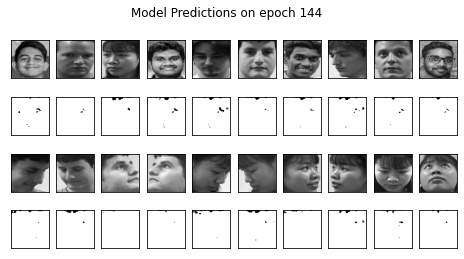

256/256 [==============================] - 264s 1s/step - loss: 0.0284 - val_loss: 0.0341
Epoch 146/148
256/256 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00146: loss did not improve from 0.02801


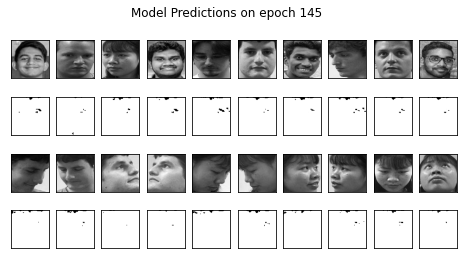

256/256 [==============================] - 264s 1s/step - loss: 0.0282 - val_loss: 0.0346
Epoch 147/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00147: loss did not improve from 0.02801


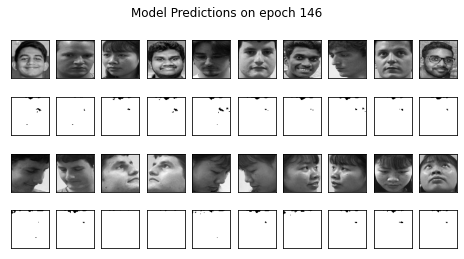

256/256 [==============================] - 263s 1s/step - loss: 0.0285 - val_loss: 0.0342
Epoch 148/148
256/256 [==============================] - ETA: 0s - loss: 0.0285
Epoch 00148: loss did not improve from 0.02801


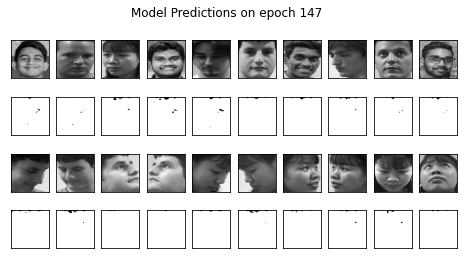

256/256 [==============================] - 264s 1s/step - loss: 0.0285 - val_loss: 0.0348


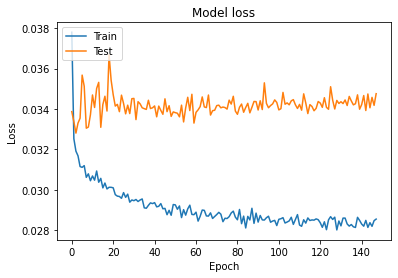

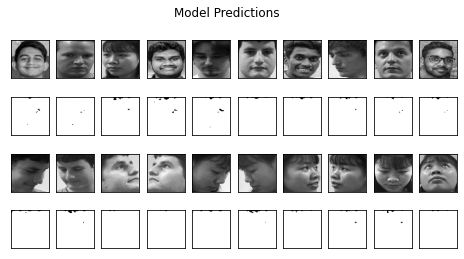

In [6]:
speculo.train()